In [1]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

PyTorch version: 2.5.1+cu121
CUDA available: True


In [2]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset 
import torch
from datetime import datetime
import json
import re
from sklearn.utils.multiclass import unique_labels
import seaborn as sns
import matplotlib.pyplot as plt

# Setari
DATA_PATH = "discharge-notes"
MODEL_NAME = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
TEXT_COLUMNS = ['chief_complaint', 'history_of_present_illness']
TARGET_COLUMN = "discharge_disposition"
MAX_LEN = 512
NUM_ROWS = 200000
EPOCHS = 3

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
OUTPUT_DIR = f"lab5_v3/pubmedbert_{timestamp}"
LOG_DIR = f"logs3/lab5_v3/pubmedbert_{timestamp}"

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

/bigdata/userhome/students/md5_sdbe65dc26b09e0608d639c245b5/nlp_clean/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Citirea datelor
print("=== Citirea datelor ===")
train_df = pd.read_csv(os.path.join(DATA_PATH, "train.csv")).head(NUM_ROWS)
val_df = pd.read_csv(os.path.join(DATA_PATH, "val.csv")).head(NUM_ROWS//10)
test_df = pd.read_csv(os.path.join(DATA_PATH, "test.csv")).head(NUM_ROWS//10)
print("Datele au fost citite cu succes.")

=== Citirea datelor ===
Datele au fost citite cu succes.


In [4]:
# Curatarea si combinarea textului
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9.,;:()\- ]', '', text)
    return text.strip()

def combine_text(row):
    return " ".join([clean_text(row[col]) for col in TEXT_COLUMNS if pd.notnull(row[col])])

print("=== Preprocesarea textului ===")
for df in [train_df, val_df, test_df]:
    df['text'] = df.apply(combine_text, axis=1)
print("Preprocesarea textului finalizata.")

# Normalizarea etichetelor
def normalize_discharge_label(label):
    if pd.isna(label):
        return None
    label_lower = label.lower()
    
    if "home" in label_lower and "service" not in label_lower:
        return "Home"
    elif "home with service" in label_lower or "home service" in label_lower:
        return "Home With Service Facility"
    elif "extended care" in label_lower or "rehab" in label_lower or "skilled nursing" in label_lower:
        return "Extended Care Facility"
    elif "expired" in label_lower or "death" in label_lower or "deceased" in label_lower:
        return "Expired"
    else:
        return "Extended Care Facility"

for df in [train_df, val_df, test_df]:
    df['label'] = df[TARGET_COLUMN].apply(normalize_discharge_label)
    df.dropna(subset=['label'], inplace=True)

# Label Mapping
labels = ["Home", "Home With Service Facility", "Extended Care Facility", "Expired"]
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for label, i in label2id.items()}

for df in [train_df, val_df, test_df]:
    df['label'] = df['label'].map(label2id).astype('int64')

with open(os.path.join(OUTPUT_DIR, "label_mappings.json"), "w") as f:
    json.dump({"label2id": label2id, "id2label": id2label}, f, indent=4)

# Dataseturi HuggingFace
train_dataset = Dataset.from_pandas(train_df[['text','label']], preserve_index=False)
val_dataset   = Dataset.from_pandas(val_df[['text','label']], preserve_index=False)
test_dataset  = Dataset.from_pandas(test_df[['text','label']], preserve_index=False)

=== Preprocesarea textului ===
Preprocesarea textului finalizata.


In [5]:

# Tokenizare
print("=== Tokenizarea textului ===")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=MAX_LEN)

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset   = val_dataset.map(tokenize, batched=True)
test_dataset  = test_dataset.map(tokenize, batched=True)

train_dataset.set_format('torch', columns=['input_ids','attention_mask','label'])
val_dataset.set_format('torch', columns=['input_ids','attention_mask','label'])
test_dataset.set_format('torch', columns=['input_ids','attention_mask','label'])
print("Tokenizare completa.")

=== Tokenizarea textului ===


Map: 100%|██████████| 18952/18952 [00:16<00:00, 1127.97 examples/s]

Tokenizare completa.


In [6]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

PyTorch version: 2.5.1+cu121
CUDA available: True


In [7]:
# Incarcarea modelului
print("=== Incarcarea modelului ===")
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    use_safetensors=True
)

#  Metrics
def compute_metrics(pred):
    logits, labels = pred
    preds = logits.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    prec = precision_score(labels, preds, average='weighted', zero_division=0)
    rec = recall_score(labels, preds, average='weighted', zero_division=0)
    return {'accuracy': acc, 'f1': f1, 'precision': prec, 'recall': rec}

# Training Arguments
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=16,
    logging_dir=LOG_DIR,
    logging_strategy="steps",
    do_eval=True,
    eval_strategy="steps", 
    logging_steps=2000,
    eval_steps=2000,
    save_strategy="steps",
    save_steps=2000,
    save_total_limit=2, 
    learning_rate=2e-5,         
    fp16=True,
    dataloader_num_workers=8,
    dataloader_pin_memory=True,
    load_best_model_at_end=True,        
    metric_for_best_model="f1",        
    greater_is_better=True,
)

# Trainer
print("=== Crearea Trainerului ===")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train
print("=== Training model ===")
trainer.train()
print("Training completed.")

=== Incarcarea modelului ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


=== Crearea Trainerului ===
=== Training model ===


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
2000,0.858500,0.792282,0.663649,0.655361,0.650399,0.663649
4000,0.791400,0.776016,0.672755,0.657433,0.653161,0.672755
6000,0.775800,0.769544,0.675229,0.668893,0.672321,0.675229
8000,0.732100,0.768177,0.681861,0.664619,0.661679,0.681861
10000,0.724000,0.752181,0.684335,0.672581,0.670224,0.684335
12000,0.718400,0.771774,0.685704,0.673423,0.670219,0.685704
14000,0.674600,0.771159,0.687020,0.675212,0.672180,0.687020
16000,0.664000,0.764838,0.683546,0.676275,0.672811,0.683546


Training completed.


=== Predictia pe setul de test ===


=== Raport de clasificare ===
                            precision    recall  f1-score   support

                      Home       0.77      0.84      0.80      9947
Home With Service Facility       0.51      0.44      0.47      4745
    Extended Care Facility       0.60      0.60      0.60      3733
                   Expired       0.60      0.29      0.39       527

                  accuracy                           0.68     18952
                 macro avg       0.62      0.54      0.57     18952
              weighted avg       0.67      0.68      0.67     18952



=== Confusion Matrix ===


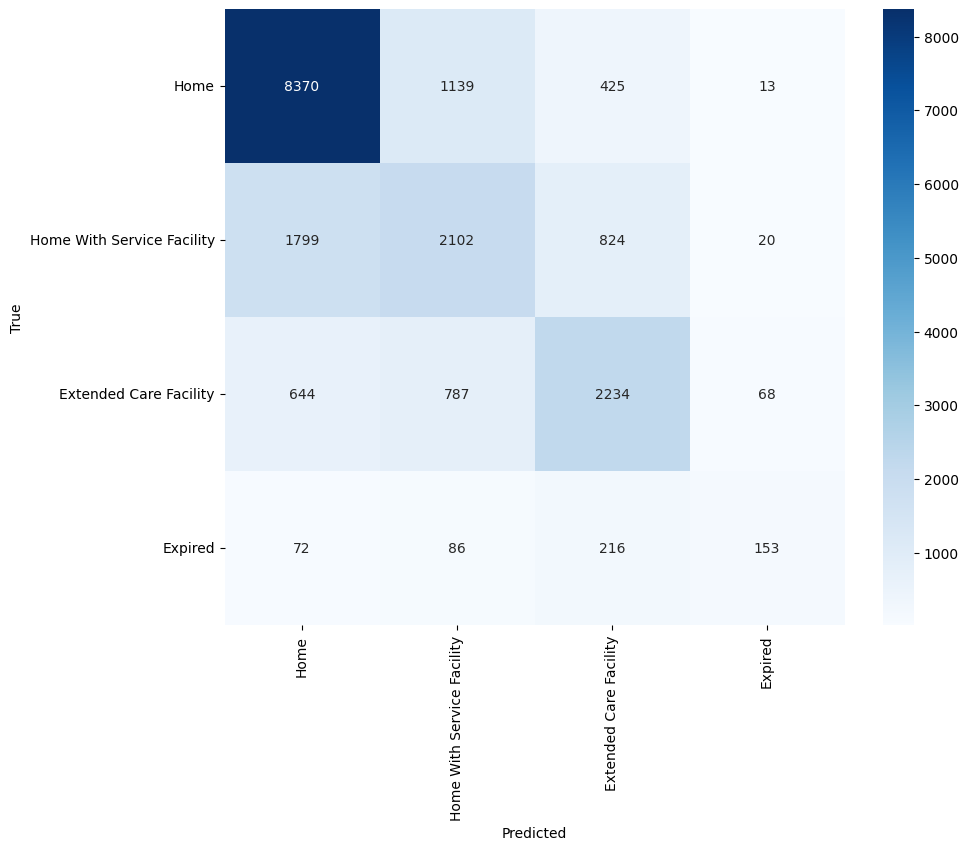

Done.


In [8]:
# Predictii si evaluari
print("=== Predictia pe setul de test ===")
preds = trainer.predict(test_dataset)
y_true = preds.label_ids
y_pred = preds.predictions.argmax(-1)
labels_present = unique_labels(y_true, y_pred)

print("=== Raport de clasificare ===")
print(classification_report(
    y_true,
    y_pred,
    labels=labels_present,
    target_names=[id2label[i] for i in labels_present]
))

results = trainer.evaluate(test_dataset)
with open(os.path.join(OUTPUT_DIR, "eval_results.json"), "w") as f:
    json.dump(results, f, indent=4)

# Salvarea modelului
trainer.save_model(OUTPUT_DIR)

# Matricea de confuzie
print("=== Confusion Matrix ===")
cm = confusion_matrix(y_true, y_pred, labels=labels_present)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=[id2label[i] for i in labels_present],
            yticklabels=[id2label[i] for i in labels_present], cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
print("Done.")